In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from fuzzywuzzy import process

In [7]:
data_df = pd.read_csv("web_scrape_files/CSV Files/data_df.csv", index_col=0)

WS_rank = pd.read_csv("web_scrape_files/CSV Files/WS_Rank.csv")
MS_rank = pd.read_csv("web_scrape_files/CSV Files/MS_Rank.csv")
WD_rank = pd.read_csv("web_scrape_files/CSV Files/WD_Rank.csv")
MD_rank = pd.read_csv("web_scrape_files/CSV Files/MD_Rank.csv")
XD_rank = pd.read_csv("web_scrape_files/CSV Files/XD_Rank.csv")

In [8]:
#Fix the h2h analysis to be the stats pre-match (subtract 1 from the match winner)
data_df = data_df[data_df['Retired'] != True].reset_index(drop=True)

for idx, row in data_df.iterrows():
    match_winner = row['Match Winner']
    
    if match_winner == 1:
        data_df.at[idx, 'Team 1 Head to Head Analysis'] = row['Team 1 Head to Head Analysis'] - 1
    
    elif match_winner == 2:
        data_df.at[idx, 'Team 2 Head to Head Analysis'] = row['Team 2 Head to Head Analysis'] - 1


In [9]:
WS_df = data_df[data_df['Discipline'] == 'WS'].reset_index(drop=True)
MS_df = data_df[data_df['Discipline'] == 'MS'].reset_index(drop=True)
WD_df = data_df[data_df['Discipline'] == 'WD'].reset_index(drop=True)
MD_df = data_df[data_df['Discipline'] == 'MD'].reset_index(drop=True)
XD_df = data_df[data_df['Discipline'] == 'XD'].reset_index(drop=True)

In [10]:
WS_rank["Date"] = pd.to_datetime(WS_rank["Date"])
MS_rank["Date"] = pd.to_datetime(MS_rank["Date"])
WD_rank["Date"] = pd.to_datetime(WD_rank["Date"])
MD_rank["Date"] = pd.to_datetime(MD_rank["Date"])
XD_rank["Date"] = pd.to_datetime(XD_rank["Date"])

def add_rankings_to_df(df, rank_df, players, date_column):
    # Add columns for rankings and points
    for i, player in enumerate(players, 1):
        df[f'Team {i} World Ranking (at the time)'] = None
        df[f'Team {i} Points Accumulated'] = None

    for idx, row in df.iterrows():
        match_date = pd.to_datetime(row[date_column])

        # Filter the ranking DataFrame by date, ensuring the date is properly handled
        filtered_rank_df = rank_df[pd.to_datetime(rank_df['Date']) <= match_date]

        if not filtered_rank_df.empty:
            # Only consider records within a month of the match date
            filtered_rank_df = filtered_rank_df[filtered_rank_df['Date'] >= (match_date - pd.DateOffset(months=1))]
            closest_date_row = filtered_rank_df.iloc[(filtered_rank_df['Date'] - match_date).abs().argsort()[:1]]
            # Match player names with rankings and points
            for i, player in enumerate(players, 1):
                player_name = row[player]
                if ',' in player_name:
                    player_name = player_name.split(',')[0].strip()
                possible_names = filtered_rank_df['Name'].tolist()
                match_result = process.extractOne(player_name, possible_names)
                # Find the player's rank from the filtered rankings
                player_rank = filtered_rank_df[filtered_rank_df['Name'] == player_name]

                if not player_rank.empty:
                    df.at[idx, f'Team {i} World Ranking (at the time)'] = player_rank.iloc[0]['Rank']
                    df.at[idx, f'Team {i} Points Accumulated'] = player_rank.iloc[0]['Points Accumulated'].replace(',', '')
    return df


WS_df = add_rankings_to_df(WS_df, WS_rank, ['Team 1 Name(s)', 'Team 2 Name(s)'], 'Tournament Date')
MS_df = add_rankings_to_df(MS_df, MS_rank, ['Team 1 Name(s)', 'Team 2 Name(s)'], 'Tournament Date')
WD_df = add_rankings_to_df(WD_df, WD_rank, ['Team 1 Name(s)', 'Team 2 Name(s)'], 'Tournament Date')
MD_df = add_rankings_to_df(MD_df, MD_rank, ['Team 1 Name(s)', 'Team 2 Name(s)'], 'Tournament Date')
XD_df = add_rankings_to_df(XD_df, XD_rank, ['Team 1 Name(s)', 'Team 2 Name(s)'], 'Tournament Date')


In [11]:
def determine_upset(df):
    rows_to_remove = []
    for idx, row in df.iterrows():
        team_1_rank = row['Team 1 World Ranking (at the time)']
        team_2_rank = row['Team 2 World Ranking (at the time)']
        
        team_1_rank = float('inf') if pd.isna(team_1_rank) else team_1_rank
        team_2_rank = float('inf') if pd.isna(team_2_rank) else team_2_rank
        
        if team_1_rank == float('inf') and team_2_rank == float('inf'):
            rows_to_remove.append(idx)
        
        match_winner = row['Match Winner']
        if df.at[idx, 'Sets Won Team 1'] > df.at[idx, 'Sets Won Team 2']:  # Team 1 wins
            if team_1_rank <= team_2_rank: # Team 1 wins
                df.at[idx, 'Match Winner'] = 0  # Upset did not occur, Higher ranked team won
            else:
                df.at[idx, 'Match Winner'] = 1  # Upset Occured, Lower ranked team won
        else:  # Team 2 wins
            if team_2_rank <= team_1_rank:
                df.at[idx, 'Match Winner'] = 0  # No upset, higher ranked team won
            else:
                df.at[idx, 'Match Winner'] = 1  # Upset, lower ranked team won
 
    
    df = df.drop(rows_to_remove)
    df = df.reset_index(drop=True)
    df = df.rename(columns={'Match Winner':'Upset'})

    return df


WS_df = determine_upset(WS_df)
MS_df = determine_upset(MS_df)
WD_df = determine_upset(WD_df)
MD_df = determine_upset(MD_df)
XD_df = determine_upset(XD_df)

**The goal is to predict the probability that the higher-ranked player will win a badminton match. -> be able to forecast the winner of a badminton match**

In [12]:
WS_df.to_csv('WS_Final_df.csv', index=True)
MS_df.to_csv('MS_Final_df.csv', index=True)
WD_df.to_csv('WD_Final_df.csv', index=True)
MD_df.to_csv('MD_Final_df.csv', index=True)
XD_df.to_csv('XD_Final_df.csv', index=True)

In [13]:
#Clean and Prep Data -> Fix/get rid of useless data + Encode non-numeric data types
WS_df["Tournament Date"] = pd.to_datetime(WS_df["Tournament Date"])
MS_df["Tournament Date"] = pd.to_datetime(MS_df["Tournament Date"])
WD_df["Tournament Date"] = pd.to_datetime(WD_df["Tournament Date"])
MD_df["Tournament Date"] = pd.to_datetime(MD_df["Tournament Date"])
XD_df["Tournament Date"] = pd.to_datetime(XD_df["Tournament Date"])


WS_df = WS_df[WS_df['Retired'] != 1].reset_index(drop=True)
MS_df = MS_df[MS_df['Retired'] != 1].reset_index(drop=True)
XD_df = XD_df[XD_df['Retired'] != 1].reset_index(drop=True)
MD_df = MD_df[MD_df['Retired'] != 1].reset_index(drop=True)
WD_df = WD_df[WD_df['Retired'] != 1].reset_index(drop=True)


def convert_to_num(df):
    columns_names = ["Team 1 World Ranking (at the time)", "Team 2 World Ranking (at the time)",
                    "Team 1 Points Accumulated", "Team 2 Points Accumulated"]
    for col in columns_names:
        df[col] = pd.to_numeric(df[col])
    return df

def encode_str(df):
    columns_names = ["Tournament Country", "Team 1 Nationalities",
                    "Team 2 Nationalities", "Team 1 Name(s)", "Team 2 Name(s)"]

    encoder = LabelEncoder()
    for col in columns_names:
        df[col] = encoder.fit_transform(df[col])
    return df

In [14]:
WS_Model_df = encode_str(convert_to_num(WS_df))
MS_Model_df = encode_str(convert_to_num(MS_df))
XD_Model_df = encode_str(convert_to_num(XD_df))
MD_Model_df = encode_str(convert_to_num(MD_df))
WD_Model_df = encode_str(convert_to_num(WD_df))

WS_Model_df.to_csv('WS_Model_df.csv', index=True)
MS_Model_df.to_csv('MS_Model_df.csv', index=True)
WD_Model_df.to_csv('WD_Model_df.csv', index=True)
MD_Model_df.to_csv('MD_Model_df.csv', index=True)
XD_Model_df.to_csv('XD_Model_df.csv', index=True)

In [62]:
rf = RandomForestClassifier(n_estimators=30, min_samples_split=10, random_state=1)
train = WS_Model_df[WS_Model_df["Tournament Date"] < "2024-01-01"]
test = WS_Model_df[WS_Model_df["Tournament Date"] > "2024-01-01"]
predictors = ["Tournament Country", 
              "Team 1 Nationalities", "Team 2 Nationalities",
             #"Team 1 Name(s)", "Team 2 Name(s)", 
              "Team 1 Seed", "Team 2 Seed", 
              "Team 1 Head to Head Analysis","Team 2 Head to Head Analysis", 
              "Team 1 World Ranking (at the time)","Team 2 World Ranking (at the time)",
             "Team 1 Points Accumulated", "Team 2 Points Accumulated"
             ]
rf.fit(train[predictors], train["Upset"])
preds = rf.predict(test[predictors])
acc = accuracy_score(test["Upset"], preds)

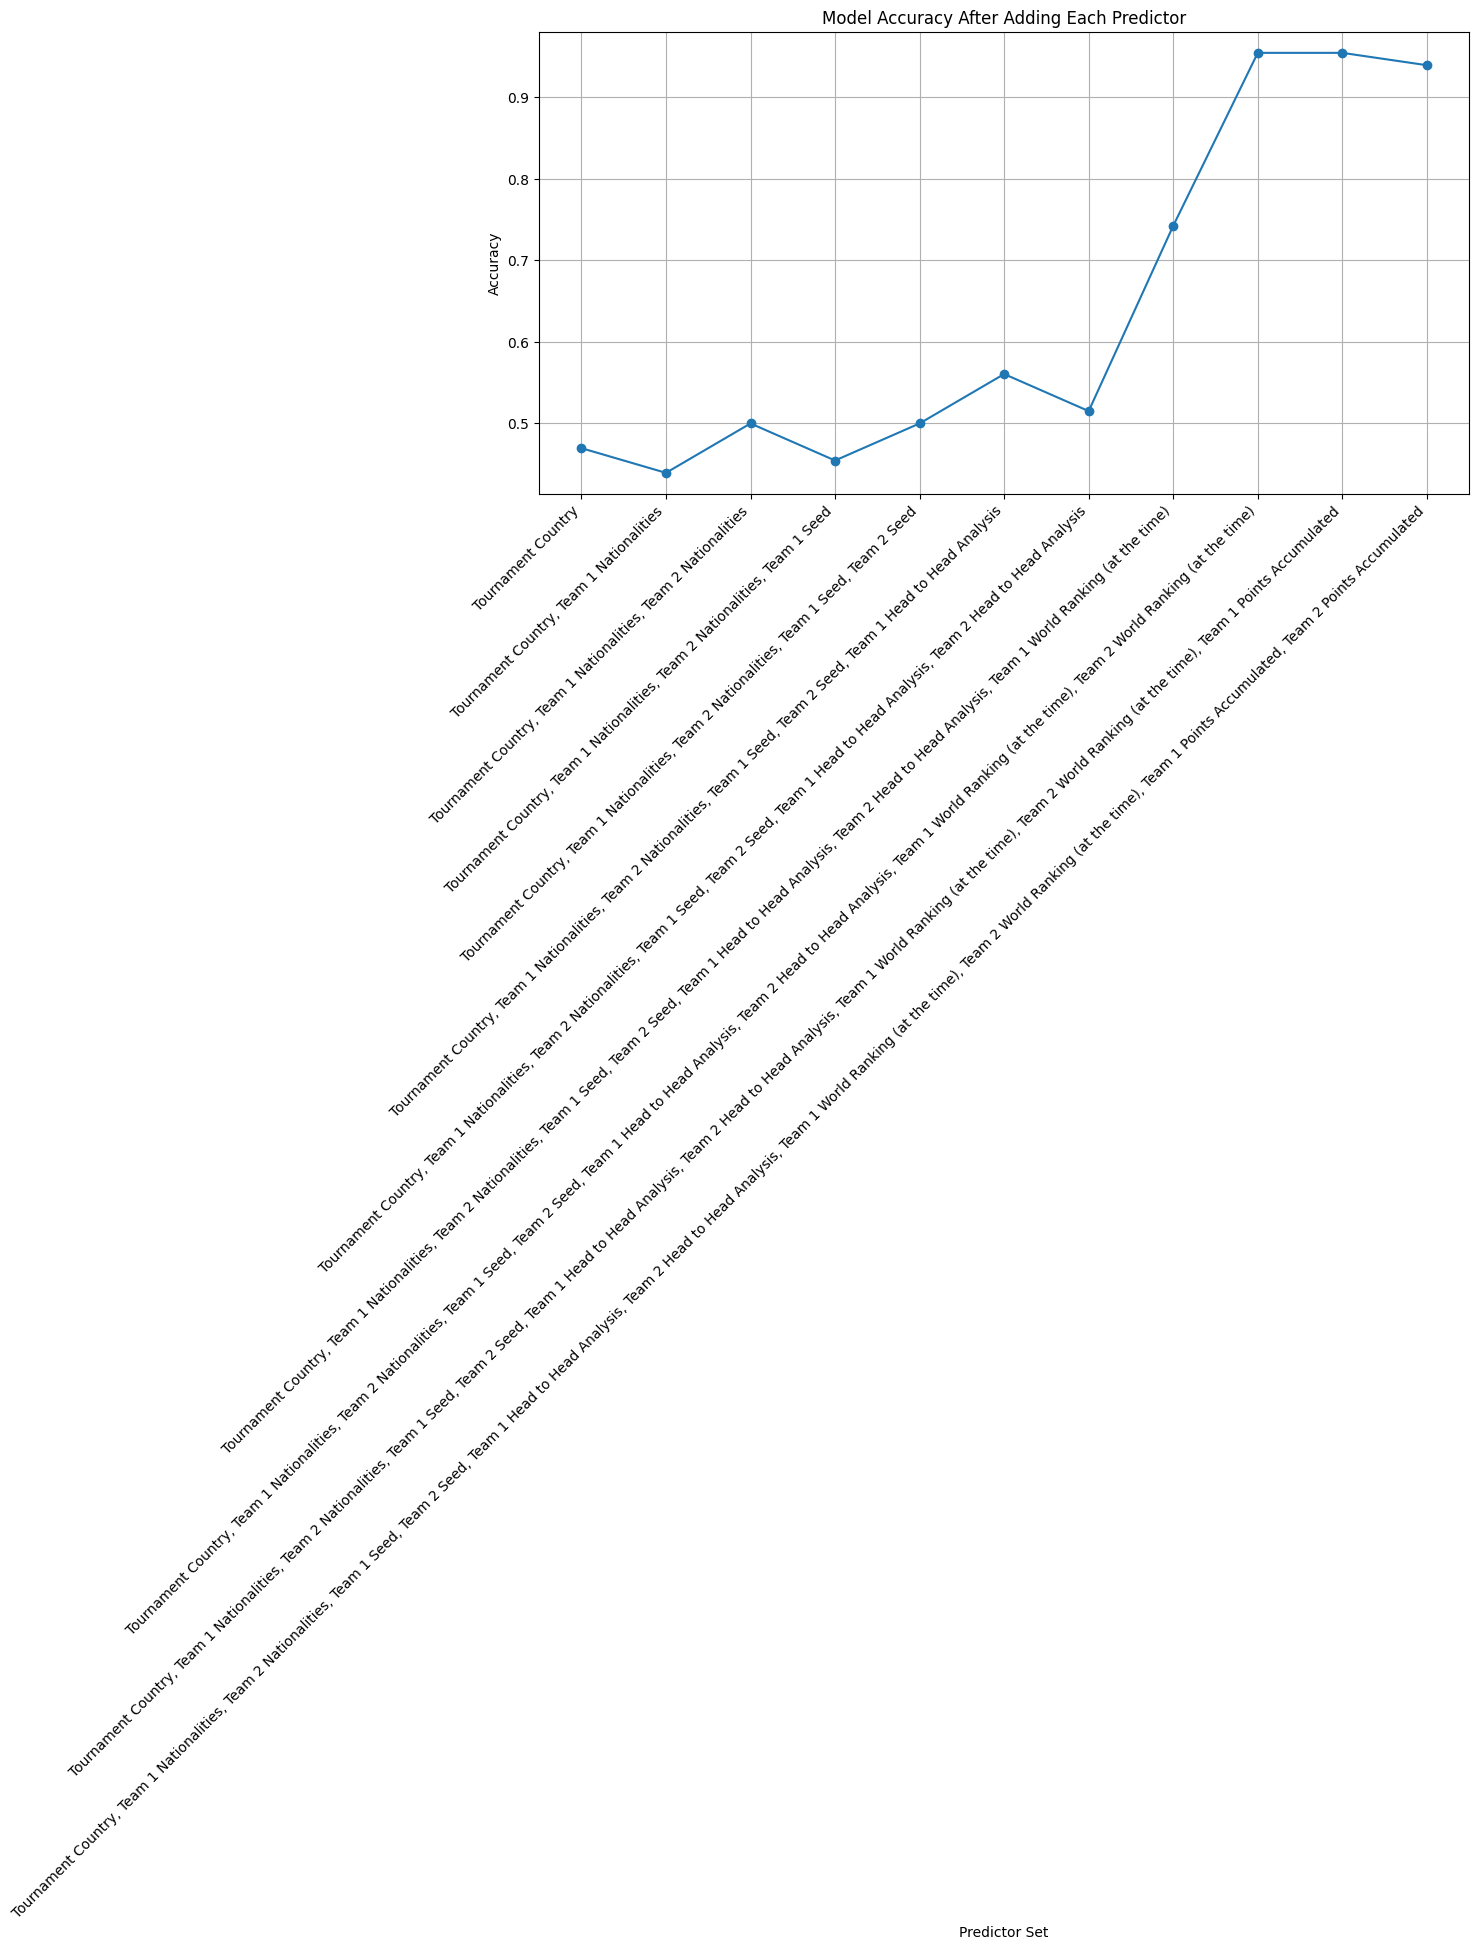

In [65]:
accs = []
predictor_sets = []
best_acc = 0

# Evaluate change of accuracy after adding each predictor
for i in range(len(predictors)):
    pred_list = predictors[:i+1]
    predictor_sets.append(pred_list)
    
    rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
    rf.fit(train[pred_list], train["Upset"])
    
    # Predict and calculate accuracy
    preds = rf.predict(test[pred_list])
    acc = accuracy_score(test["Upset"], preds)
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_pred_list = pred_list

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(accs) + 1), accs, marker='o')
plt.xticks(range(1, len(accs) + 1), [', '.join(ps) for ps in predictor_sets], rotation=45, ha='right')
plt.xlabel('Predictor Set')
plt.ylabel('Accuracy')
plt.title('Model Accuracy After Adding Each Predictor')
plt.grid(True)
plt.show()


In [67]:
print(f"Best accuracy: {best_acc}")
print(f"Best predictor list: {best_pred_list}")

Best accuracy: 0.9545454545454546
Best predictor list: ['Tournament Country', 'Team 1 Nationalities', 'Team 2 Nationalities', 'Team 1 Seed', 'Team 2 Seed', 'Team 1 Head to Head Analysis', 'Team 2 Head to Head Analysis', 'Team 1 World Ranking (at the time)', 'Team 2 World Ranking (at the time)']


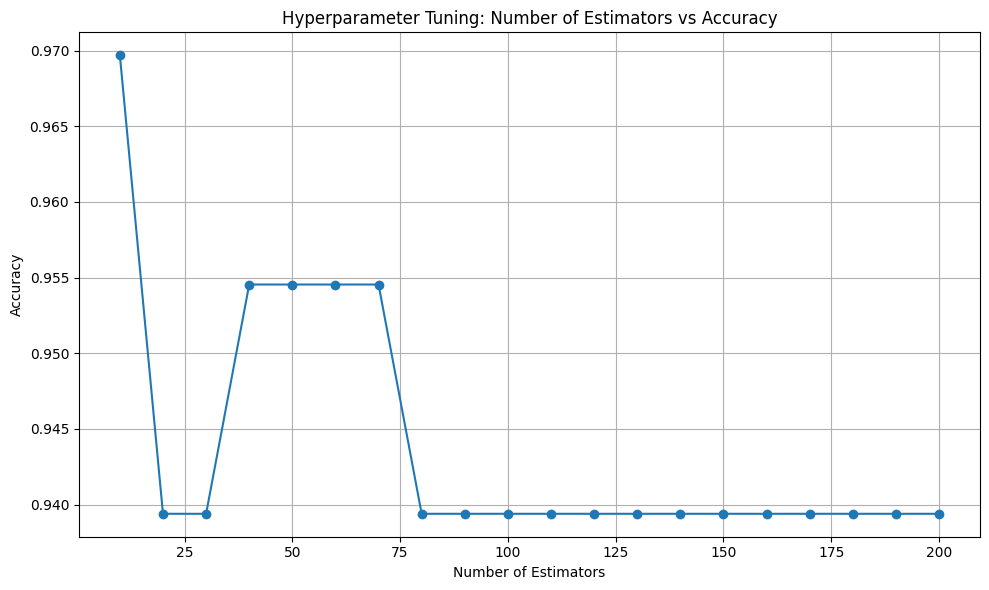

In [77]:
n_estimators_range = range(10, 201, 10)
accuracies = []
best_acc_2 = 0

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=10, random_state=1)
    rf.fit(train[best_pred_list], train["Upset"])
    preds = rf.predict(test[best_pred_list])
    accuracy = accuracy_score(test["Upset"], preds)
    accuracies.append(accuracy)
    if accuracy > best_acc_2:
        best_acc_2 = accuracy
        best_n_estimators = n_estimators

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Tuning: Number of Estimators vs Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
print(f"Best number of estimators: {best_n_estimators}")
print(f"Highest accuracy: {best_acc_2}")

Best number of estimators: 10
Highest accuracy: 0.9696969696969697


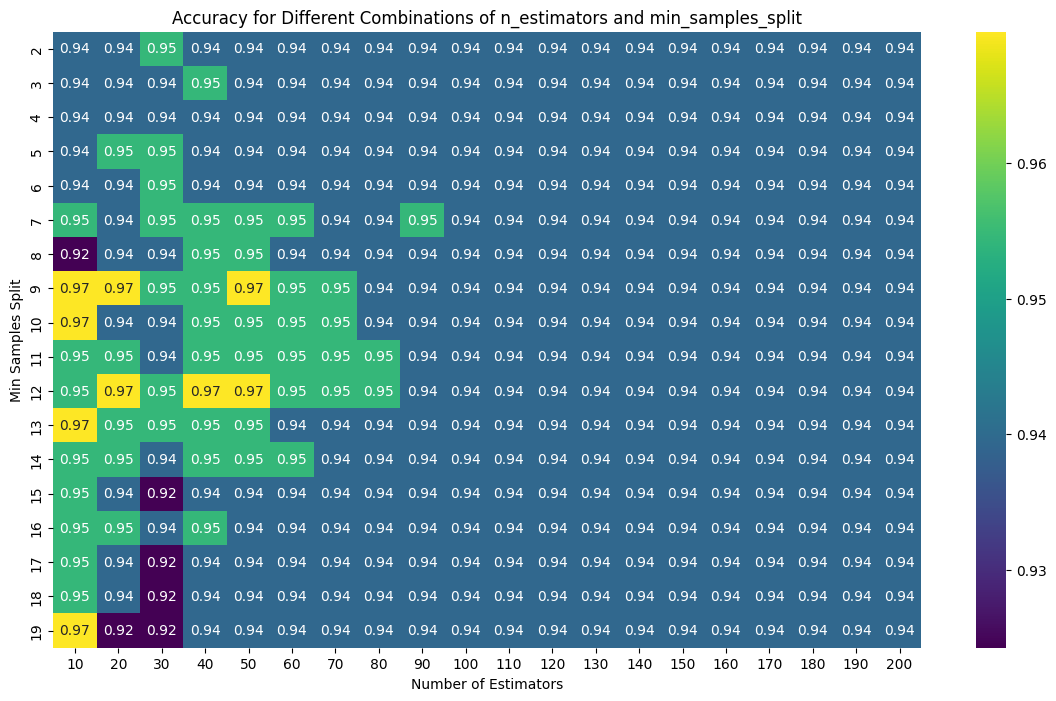

In [73]:
# Define ranges for hyperparameters
n_estimators_range = range(10, 201, 10) 
min_samples_split_range = range(2, 20, 1)

# Create a grid of parameters
param_grid = {
    'n_estimators': n_estimators_range,
    'min_samples_split': min_samples_split_range
}

# Prepare to store results
results = []

# Grid search
for params in ParameterGrid(param_grid):
    rf = RandomForestClassifier(n_estimators=params['n_estimators'],
                                min_samples_split=params['min_samples_split'],
                                random_state=1)
    rf.fit(train[best_pred_list], train["Upset"])
    preds = rf.predict(test[best_pred_list])
    accuracy = accuracy_score(test["Upset"], preds)
    results.append({
        'n_estimators': params['n_estimators'],
        'min_samples_split': params['min_samples_split'],
        'accuracy': accuracy
    })

# Convert results to DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Pivot table to get a matrix form for heatmap
results_pivot = results_df.pivot(index='min_samples_split', columns='n_estimators', values='accuracy')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(results_pivot, annot=True, cmap='viridis', fmt='.2f', cbar=True)
plt.title('Accuracy for Different Combinations of n_estimators and min_samples_split')
plt.xlabel('Number of Estimators')
plt.ylabel('Min Samples Split')
plt.show()

In [75]:
best_params = results_df.loc[results_df['accuracy'].idxmax()]
print("Best parameters:")
print(best_params)

Best parameters:
n_estimators         10.000000
min_samples_split     9.000000
accuracy              0.969697
Name: 140, dtype: float64
